<a href="https://colab.research.google.com/github/SefatSikderM/ExplainNet--Explainable-Autism-Detection/blob/main/ExplainNet_Implementation_by_mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Path to dataset
data_path = '/content/drive/MyDrive/autism_project/data_split'

# Image transforms


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
'''
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
'''
# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=val_test_transforms)
from torch.utils.data import WeightedRandomSampler
###
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transforms)

# Count and show class distribution
from collections import Counter

label_counts = Counter([sample[1] for sample in train_dataset])
class_names = train_dataset.classes

print("Class distribution in training set:")
for i, count in label_counts.items():
    print(f"{class_names[i]}: {count} images")

# Assume your dataset has `.targets` or `.samples` with labels
labels = [sample[1] for sample in train_dataset]
class_sample_count = np.array([labels.count(0), labels.count(1)])  # 0 = autistic, 1 = non_autistic
weights = 1. / class_sample_count
sample_weights = [weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


#
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", train_dataset.classes)


ValueError: mount failed

In [ ]:
# Load pretrained MobileNetV2 and modify classifier
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)  # 2 classes: autistic, non_autistic
####
# ✅ Fine-tune only selected layers
for name, param in model.named_parameters():
    if "features.14" in name or "features.15" in name or "features.16" in name or \
       "features.17" in name or "features.18" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# ✅ Move model to device (CPU or GPU)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# ✅ Learning rate scheduler to reduce LR over time
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler.step()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += torch.sum(val_preds == val_labels.data)
        val_acc = val_correct.double() / len(val_loader.dataset)
        print(f"Validation Acc: {val_acc:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)


Epoch 1/15 | Train Loss: 0.1091 | Train Acc: 0.9714
Validation Acc: 0.8000
Epoch 2/15 | Train Loss: 0.1298 | Train Acc: 0.9571
Validation Acc: 0.8667
Epoch 3/15 | Train Loss: 0.1759 | Train Acc: 0.9286
Validation Acc: 0.8667
Epoch 4/15 | Train Loss: 0.1088 | Train Acc: 0.9714
Validation Acc: 0.8667
Epoch 5/15 | Train Loss: 0.0978 | Train Acc: 1.0000
Validation Acc: 0.9333
Epoch 6/15 | Train Loss: 0.1397 | Train Acc: 0.9857
Validation Acc: 0.8667
Epoch 7/15 | Train Loss: 0.1837 | Train Acc: 0.9571
Validation Acc: 0.8000
Epoch 8/15 | Train Loss: 0.0915 | Train Acc: 0.9571
Validation Acc: 0.8000
Epoch 9/15 | Train Loss: 0.1190 | Train Acc: 0.9714
Validation Acc: 0.7333
Epoch 10/15 | Train Loss: 0.0673 | Train Acc: 1.0000
Validation Acc: 0.7333
Epoch 11/15 | Train Loss: 0.0817 | Train Acc: 0.9571
Validation Acc: 0.8000
Epoch 12/15 | Train Loss: 0.0429 | Train Acc: 1.0000
Validation Acc: 0.8000
Epoch 13/15 | Train Loss: 0.0726 | Train Acc: 0.9857
Validation Acc: 0.8000
Epoch 14/15 | Train L

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/autism_project/mobilenetv2_asd.pth')


RuntimeError: Parent directory /content/drive/MyDrive/autism_project does not exist.

In [2]:
!pip install -q opencv-python dlib pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [3]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s 

In [5]:
from pytorch_grad_cam import GradCAM


In [6]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


--2025-06-28 06:43:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-06-28 06:43:05--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  40.8MB/s    in 1.5s    

2025-06-28 06:43:07 (40.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Use modern weight loading
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)

# Load your trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/autism_project/mobilenetv2_asd.pth', map_location='cpu'))

# Safe device assignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
!pip install -q grad-cam opencv-python dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


--2025-06-28 06:49:39--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-06-28 06:49:40--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.3’

shape_predictor_68_ 100%[===================>]  61.07M  40.5MB/s    in 1.5s    

2025-06-28 06:49:41 (40.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.3’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [4]:
import torch
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model with custom classifier
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)

# Load trained weights (map to CPU)
model.load_state_dict(torch.load('/content/drive/MyDrive/autism_project/mobilenetv2_asd.pth', map_location=device))
model.eval().to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
from PIL import Image
from torchvision import transforms
import numpy as np

In [6]:


# Load and preprocess the image
img_path = "/content/drive/MyDrive/autism_project/data_split/test/autistic/0528.jpg"
image = Image.open(img_path).convert('RGB').resize((224, 224))

# For overlay
img_np = np.array(image).astype(np.float32) / 255.0

# Transform for model input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)


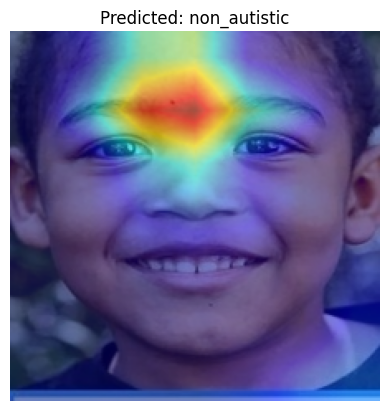

In [7]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set target layer
target_layer = model.features[-1]

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Predict class
output = model(input_tensor)
pred_class = output.argmax().item()

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

# Overlay on image
heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# Show result
import matplotlib.pyplot as plt
plt.imshow(heatmap)
plt.title(f"Predicted: {'autistic' if pred_class == 0 else 'non_autistic'}")
plt.axis('off')
plt.show()


In [8]:
import cv2
import numpy as np
import dlib

# Load image for facial landmarks
image = cv2.imread(img_path)
image = cv2.resize(image, (224, 224))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load face detector and predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()
faces = detector(gray)

# Extract masks for each region
region_masks = {}

for face in faces:
    shape = predictor(gray, face)
    def mask_from_landmarks(indices):
        points = np.array([(shape.part(i).x, shape.part(i).y) for i in indices])
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [points], 1)
        return mask

    region_masks['eyes'] = mask_from_landmarks(list(range(36, 48)))
    region_masks['mouth'] = mask_from_landmarks(list(range(48, 68)))
    region_masks['nose'] = mask_from_landmarks(list(range(27, 36)))
    region_masks['forehead'] = mask_from_landmarks([19, 24, 27, 22, 17])  # pseudo forehead zone


In [9]:
# Normalize Grad-CAM to 0–1 and resize to match masks
cam_resized = cv2.resize(grayscale_cam, (224, 224))

# Measure average activation in each region
region_scores = {}
for name, mask in region_masks.items():
    region_values = cam_resized * mask
    avg_intensity = region_values.sum() / (mask.sum() + 1e-5)  # prevent div by zero
    region_scores[name] = avg_intensity

# Sort and display
sorted_regions = sorted(region_scores.items(), key=lambda x: x[1], reverse=True)
print("Region heatmap intensities:", sorted_regions)


Region heatmap intensities: [('forehead', 0.5840922039434053), ('nose', 0.26180355795450405), ('eyes', 0.2497560687843727), ('mouth', 0.02291654116733668)]


In [10]:
# Pick top 2 regions
top_regions = [r[0] for r in sorted_regions[:2]]
explanation = f"The model focused on the {top_regions[0]} and {top_regions[1]} regions, which influenced the classification."

print("Explanation:", explanation)



Explanation: The model focused on the forehead and nose regions, which influenced the classification.


In [11]:
!pip install facenet-pytorch

from facenet_pytorch import MTCNN


In [12]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
from facenet_pytorch import MTCNN
# Setup once




from facenet_pytorch import MTCNN
import dlib

# Setup once
mtcnn = MTCNN(keep_all=False, device='cpu')  # or 'cuda' if you're using GPU
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def explain_prediction(img_path, model, cam, save_path=None):
    # Load and preprocess image
    raw = Image.open(img_path).convert('RGB').resize((224, 224))
    np_img = np.array(raw).astype(np.float32) / 255.0
    tensor = transforms.ToTensor()(raw).unsqueeze(0).to(device)

    # Predict class
    output = model(tensor)
    pred_class = output.argmax().item()
    class_name = 'autistic' if pred_class == 0 else 'non_autistic'

    # Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    heatmap = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)

    # Detect face using MTCNN
    boxes, _ = mtcnn.detect(raw)
    explanation = "No face detected. Prediction may be unreliable."

    if boxes is not None:
        x1, y1, x2, y2 = boxes[0]
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        rect = dlib.rectangle(x1, y1, x2, y2)

        # Convert to grayscale OpenCV image for dlib
        img_cv = cv2.cvtColor(np.array(raw), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

        shape = predictor(gray, rect)

        def region_mask(indices):
            points = np.array([(shape.part(i).x, shape.part(i).y) for i in indices])
            mask = np.zeros(gray.shape, dtype=np.uint8)
            cv2.fillPoly(mask, [points], 1)
            return mask

        region_masks = {
            'eyes': region_mask(list(range(36, 48))),
            'nose': region_mask(list(range(27, 36))),
            'mouth': region_mask(list(range(48, 68))),
            'forehead': region_mask([19, 24, 27, 22, 17])  # Approximate
        }

        cam_resized = cv2.resize(grayscale_cam, (224, 224))
        region_scores = {
            name: (cam_resized * mask).sum() / (mask.sum() + 1e-5)
            for name, mask in region_masks.items()
        }

        top_regions = sorted(region_scores.items(), key=lambda x: x[1], reverse=True)[:2]
        explanation = f"The model focused on the {top_regions[0][0]} and {top_regions[1][0]} regions."

    # Show and optionally save
    plt.imshow(heatmap)
    plt.title(f"Predicted: {class_name}\n{explanation}")
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

    print("Explanation:", explanation)


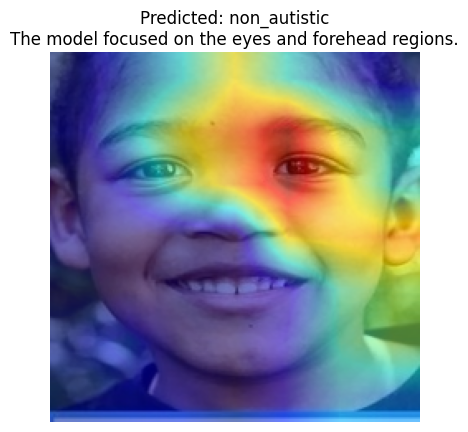

Explanation: The model focused on the eyes and forehead regions.


In [ ]:
explain_prediction("/content/drive/MyDrive/autism_project/data_split/test/autistic/0528.jpg", model, cam)


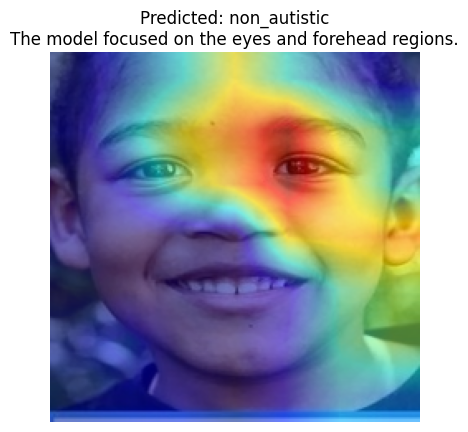

Explanation: The model focused on the eyes and forehead regions.


In [13]:
explain_prediction("/content/drive/MyDrive/autism_project/data_split/test/autistic/0528.jpg",
                   model, cam,
                   save_path="/content/drive/MyDrive/autism_project/explained_0528.png")


In [14]:
import os
import pandas as pd
from tqdm import tqdm

def batch_explain(folder_path, model, cam, output_dir, csv_path):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    # Collect all image paths
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            # Filename
            img_name = os.path.basename(img_path)
            save_path = os.path.join(output_dir, f"explain_{img_name}.png")

            # Predict + Explain
            raw = Image.open(img_path).convert('RGB').resize((224, 224))
            np_img = np.array(raw).astype(np.float32) / 255.0
            tensor = transforms.ToTensor()(raw).unsqueeze(0).to(device)

            # Forward pass
            output = model(tensor)
            pred_class = output.argmax().item()
            class_name = 'autistic' if pred_class == 0 else 'non_autistic'

            # Grad-CAM
            grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

            # Facial landmarks
            img_cv = cv2.imread(img_path)
            img_resized = cv2.resize(img_cv, (224, 224))
            gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if not faces:
                explanation = "No face detected"
            else:
                shape = predictor(gray, faces[0])
                def region_mask(indices):
                    points = np.array([(shape.part(i).x, shape.part(i).y) for i in indices])
                    mask = np.zeros(gray.shape, dtype=np.uint8)
                    cv2.fillPoly(mask, [points], 1)
                    return mask

                region_masks = {
                    'eyes': region_mask(list(range(36, 48))),
                    'nose': region_mask(list(range(27, 36))),
                    'mouth': region_mask(list(range(48, 68))),
                    'forehead': region_mask([19, 24, 27, 22, 17])
                }

                cam_resized = cv2.resize(grayscale_cam, (224, 224))
                region_scores = {
                    name: (cam_resized * mask).sum() / (mask.sum() + 1e-5)
                    for name, mask in region_masks.items()
                }
                top = sorted(region_scores.items(), key=lambda x: x[1], reverse=True)[:2]
                explanation = f"Focused on {top[0][0]} and {top[1][0]} regions."

            # Save image
            heatmap = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)
            plt.figure()
            plt.imshow(heatmap)
            plt.title(f"{class_name}\n{explanation}")
            plt.axis('off')
            plt.savefig(save_path)
            plt.close()

            # Save result to log
            results.append({
                "filename": img_name,
                "prediction": class_name,
                "explanation": explanation,
                "heatmap_image": save_path
            })

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Save CSV
    df = pd.DataFrame(results)
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Results saved to: {csv_path}")


In [ ]:
batch_explain(
    folder_path="/content/drive/MyDrive/autism_project/data_split/test/autistic",
    model=model,
    cam=cam,
    output_dir="/content/drive/MyDrive/autism_project/explanations",
    csv_path="/content/drive/MyDrive/autism_project/asd_explanations.csv"
)


Processing images: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


✅ Results saved to: /content/drive/MyDrive/autism_project/asd_explanations.csv


In [ ]:
# Define parent folder and output paths
test_root = "/content/drive/MyDrive/autism_project/data_split/test"
output_root = "/content/drive/MyDrive/autism_project/explanations"
csv_combined = "/content/drive/MyDrive/autism_project/asd_explanations.csv"

all_results = []

# Loop through both classes
for class_name in ["autistic", "non_autistic"]:
    folder_path = os.path.join(test_root, class_name)
    output_dir = os.path.join(output_root, class_name)
    temp_csv = f"/content/temp_{class_name}.csv"

    # Process each class
    batch_explain(folder_path, model, cam, output_dir, temp_csv)

    # Load partial CSV and tag class
    df_temp = pd.read_csv(temp_csv)
    df_temp["actual_label"] = class_name
    all_results.append(df_temp)

# Merge and save combined CSV
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv(csv_combined, index=False)
print(f"✅ Combined explanation CSV saved to:\n{csv_combined}")


Processing images: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]



✅ Results saved to: /content/temp_autistic.csv


Processing images: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


✅ Results saved to: /content/temp_non_autistic.csv
✅ Combined explanation CSV saved to:
/content/drive/MyDrive/autism_project/asd_explanations.csv


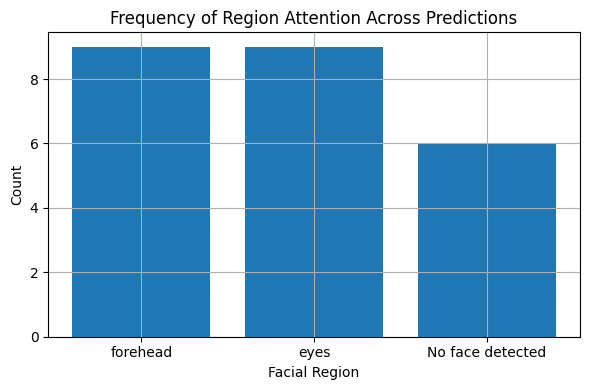

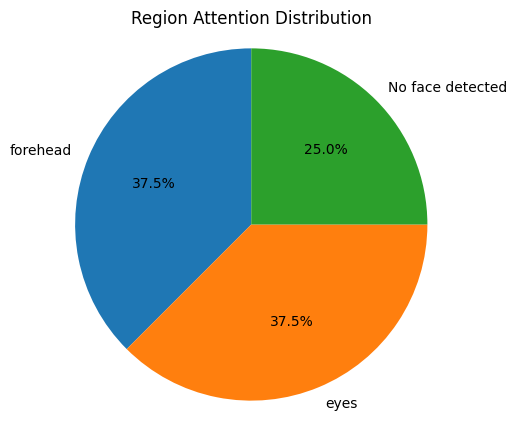

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load your explanations
csv_path = "/content/drive/MyDrive/autism_project/asd_explanations.csv"
df = pd.read_csv(csv_path)

# Extract focused regions from explanation text
def extract_regions(text):
    parts = text.replace("Focused on ", "").replace(" regions.", "").split(" and ")
    return parts

# Count region frequency
region_list = df["explanation"].dropna().apply(extract_regions).explode()
region_counts = Counter(region_list)

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(region_counts.keys(), region_counts.values())
plt.title("Frequency of Region Attention Across Predictions")
plt.xlabel("Facial Region")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(region_counts.values(), labels=region_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Region Attention Distribution")
plt.axis('equal')
plt.show()


In [15]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [16]:
!pip install pyngrok
!ngrok authtoken YOUR_NGROK_TOKEN  # get from ngrok.com


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [21]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/autism_project/mobilenetv2_asd.pth" .
!cp "/content/drive/MyDrive/autism_project/shape_predictor_68_face_landmarks.dat" .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!cp "/content/drive/MyDrive/autism_project/shape_predictor_68_face_landmarks.dat" .

In [42]:
%%writefile app.py
import streamlit as st
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import dlib


# Device setup
device = torch.device("cpu")

# Streamlit UI setup
st.set_page_config(page_title="ExplainNet ASD Predictor", layout="centered")
st.title("🧠 ExplainNet – Autism Detection with Explanation")

# Load model
@st.cache_resource
def load_model():
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = torch.nn.Linear(model.last_channel, 2)
    model.load_state_dict(torch.load("mobilenetv2_asd.pth", map_location='cpu'))
    model.eval()
    return model

model = load_model()
cam = GradCAM(model=model, target_layers=[model.features[-1]])
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()
from facenet_pytorch import MTCNN
mtcnn = MTCNN(keep_all=False, device=device)

# File upload
uploaded_file = st.file_uploader("📤 Upload a facial image", type=["jpg", "jpeg", "png"])
def detect_face_combined(image_np):
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # MTCNN Detection
    mtcnn_box = None
    try:
        box = mtcnn.detect(Image.fromarray(image_np))[0]
        if box is not None:
            mtcnn_box = box[0]  # (x1, y1, x2, y2)
    except:
        pass

    # dlib Detection
    dlib_faces = detector(gray)

    return mtcnn_box, dlib_faces

if uploaded_file:
    # Load original image
    orig_img = Image.open(uploaded_file).convert("RGB")
    st.image(orig_img, caption="📷 Uploaded Image", use_container_width=True)

    # Resize image for processing
    resized_img = orig_img.resize((224, 224))
    np_img = np.array(resized_img).astype(np.float32) / 255.0

    # Apply transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(resized_img).unsqueeze(0).to(device)

    mtcnn_box, dlib_faces = detect_face_combined(np.array(resized_img))

    if mtcnn_box is None and len(dlib_faces) == 0:
        st.warning("⚠️ No clear human face detected. Prediction may be unreliable.")
        explanation = "No face detected. The prediction may not be accurate."
    else:
        explanation = ""



    # Predict
    output = model(input_tensor)
    prob = torch.nn.functional.softmax(output, dim=1)
    confidence, pred_class = torch.max(prob, 1)
    pred_label = "Autistic" if pred_class.item() == 0 else "Non-Autistic"

    # Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class.item())])[0]
    cam_img = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)
    st.image(cam_img, caption=f"🔍 Prediction: **{pred_label}** ({confidence.item():.2f})", use_container_width=True)

    # Facial landmarks and region explanation (dlib)
    gray_dlib = cv2.cvtColor(np.array(resized_img), cv2.COLOR_RGB2GRAY)
    faces_dlib = detector(gray_dlib)
    explanation = "No face landmarks detected."

    if faces_dlib:
        shape = predictor(gray_dlib, faces_dlib[0])

        def region_mask(indices):
            points = np.array([(shape.part(i).x, shape.part(i).y) for i in indices])
            mask = np.zeros(gray_dlib.shape, dtype=np.uint8)
            cv2.fillPoly(mask, [points], 1)
            return mask

        region_masks = {
            'eyes': region_mask(list(range(36, 48))),
            'nose': region_mask(list(range(27, 36))),
            'mouth': region_mask(list(range(48, 68))),
            'forehead': region_mask([19, 24, 27, 22, 17])
        }

        cam_resized = cv2.resize(grayscale_cam, (224, 224))
        region_scores = {
            name: (cam_resized * mask).sum() / (mask.sum() + 1e-5)
            for name, mask in region_masks.items()
        }

        top = sorted(region_scores.items(), key=lambda x: x[1], reverse=True)[:2]
        explanation = f"The model focused on the **{top[0][0]}** and **{top[1][0]}** regions."

    st.markdown(f"📝 **Explanation**: {explanation}")



Writing app.py


In [43]:
!cp app.py /content/drive/MyDrive/autism_project


In [28]:
!ngrok authtoken 2z5cZf0FnuKQh29RtSlFGR20FWB_7x7Tvvdz2XGBVX7u5nm7B


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [25]:
!pkill -f ngrok


In [29]:
from pyngrok import ngrok
import threading
import os

def run():
    os.system("streamlit run app.py")

threading.Thread(target=run).start()
public_url = ngrok.connect(8501)
print("🚀 Streamlit app is live at:", public_url)


🚀 Streamlit app is live at: NgrokTunnel: "https://62cd-34-150-194-174.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Final evaluation on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


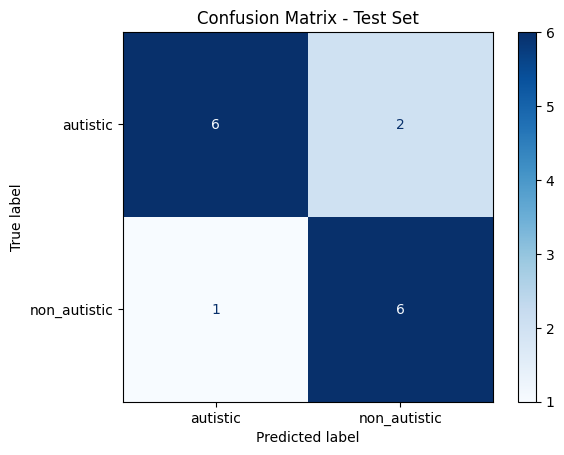

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
import os

base = "/content/drive/MyDrive/autism_project"
folders = ["training", "evaluation", "models", "streamlit_app"]

for folder in folders:
    os.makedirs(os.path.join(base, folder), exist_ok=True)

print("📁 All folders created.")


📁 All folders created.


In [ ]:
torch.save(model.state_dict(), f"{base}/models/mobilenetv2_asd.pth")
print("✅ Model saved.")


✅ Model saved.


In [32]:
''''%%writefile /content/drive/MyDrive/autism_project/streamlit_app/app.py
# PASTE your working app.py code here
!cp /content/ExplainNet_Implementation_by_mobileNet.ipynb /content/drive/MyDrive/autism_project/training/train_model.ipynb
%%writefile /content/drive/MyDrive/autism_project/README.md
# ExplainNet – Autism Detection Framework

## Structure
- `training/train_model.ipynb` – MobileNetV2 training with balanced sampling
- `evaluation/` – Evaluation notebooks (add as needed)
- `models/` – Trained `.pth` models
- `streamlit_app/app.py` – Streamlit UI
- `shape_predictor_68_face_landmarks.dat` – Landmark model for Grad-CAM explanation

## How to Use
1. Train or load a saved model
2. Run `app.py` with Streamlit to test images
3. Upload facial image and view prediction + explanation

## Notes
- Model accuracy: ~80% with balanced sampling
- Use `WeightedRandomSampler` and data augmentation
'''

Overwriting /content/drive/MyDrive/autism_project/streamlit_app/app.py


In [37]:
!cp app.py /content/drive/MyDrive/autism_project/

In [44]:
%%writefile requirements.txt
torch>=1.12.0
torchvision>=0.13.0
numpy
opencv-python-headless
Pillow
matplotlib
streamlit
pytorch-grad-cam
facenet-pytorch
dlib


Writing requirements.txt
